Бейзлайн. Можно использовать как шаблон.

# Импорты и библиотеки

In [1]:
!pip install -q polars tqdm scikit-learn

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
#from tqdm.notebook import tqdm
from tqdm import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


def dataframe_to_html(df: pl.DataFrame, columns: list) -> str:
    """
    Convert a Polars DataFrame to an HTML table with specified columns.

    Args:
        df: Polars DataFrame containing the data.
        columns: List of column names to include in the HTML table.

    Returns:
        str: HTML string representing the table.
    """
    html = ["<table border='1'>"]

    html.append("<tr>")
    for col in columns:
        html.append(f"<th>{col}</th>")
    html.append("</tr>")

    for row in df.iter_rows(named=True):
        html.append("<tr>")
        for col in columns:
            value = row[col]
            if col == "image_url":
                html.append(f"<td><img src='{value}' width='100' /></td>")
            else:
                html.append(f"<td>{value}</td>")
        html.append("</tr>")

    html.append("</table>")
    return "\n".join(html)


# Посмотрим на данные 

Более подробный обзор данных можно (но не обязательно нужно) найти [по ссылке](https://github.com/MengtingWan/goodreads/tree/master?tab=readme-ov-file).

In [3]:
data_folder = "data/"

**Train**
* `user_id` - уникальный идентификатор пользователя
* `item_id` - уникальный идентификатор книги
* `is_read` - прочитал ли пользователь книгу или только добавил в избранное
* `rating` - рейтинг, поставленный книге пользователем (0, если пользователь не оставил рейтинг)
* `date_added` - дата добавления книги в избранное

In [4]:
train = pl.read_parquet(data_folder + "train.pq")
print("Train:")
print(train.shape)
display(train.head(5))

Train:
(11971437, 5)


user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20


**Test**
* `user_id` - уникальный идентификатор пользователя
* `item_id` - список уникальных идентификатор книг, с которыми пользователь провзаимодействовал в течение тестового периода, отсортированный по релевантности 

In [5]:
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
print("Test:")
print(test.shape)
display(test.head(5))

Test:
(185828, 2)


user_id,item_id
str,list[i64]
"""00000377eea48021d3002730d56aca…",[13252]
"""00009ab2ed8cbfceda5a59da409663…",[2328]
"""00009e46d18f223a82b22da38586b6…","[28636, 30197]"
"""0001085188e302fc6b2568de45a5f5…","[2159, 2969, … 33630]"
"""00014c578111090720e20f5705eba0…","[45, 3513, … 33273]"


In [6]:
# в тесте нет холодных пользователей
len(set(test["user_id"].to_list()) - set(train["user_id"].to_list()))

0

In [7]:
# но есть холодные айтемы
len(set(test_exploded["item_id"].to_list()) - set(train["item_id"].to_list()))

1775

**Books**
* `item_id` - уникальный идентификатор книги
* `series` - если книга является частью серии, то это список идентификаторов серии
* `tags` - список проставленных пользователями тегов
* `title` - название книги
* `description` - описание книги
* `url` - ссылка на книгу на Goodreads
* `image_url` - обложка книги
* `authors` - список авторов книги в формате пар (автор, роль)

In [8]:
books = pl.read_parquet(data_folder + "books.pq")
print("Books:")
print(books.shape)
display(books.head(5))

Books:
(34322, 8)


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"


Взглянем на пару книг

In [9]:
HTML(dataframe_to_html(books.sample(5), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
12005,"Falling Kingdoms (Falling Kingdoms, #1)","In a land where magic has been forgotten but peace has reigned for centuries, a deadly unrest is simmering. Three kingdoms grapple for power--brutally transforming their subjects' lives in the process. Amidst betrayals, bargains, and battles, four young people find their fates forever intertwined: Cleo: A princess raised in luxury must embark on a rough and treacherous journey into enemy territory in search of a magic long thought extinct. Jonas: Enraged at injustice, a rebel lashes out against the forces of oppression that have kept his country impoverished--and finds himself the leader of a people's revolution centuries in the making. Lucia: A girl adopted at birth into a royal family discovers the truth about her past--and the supernatural legacy she is destined to wield. Magnus: Bred for aggression and trained to conquer, a firstborn son begins to realize that the heart can be more lethal than the sword... The only outcome that's certain is that kingdoms will fall. Who will emerge triumphant when all they know has collapsed? ""Falling Kingdoms will gut you emotionally. It will make you ache, cry, and beg for the sequel as you turn the last page. I absolutely loved it.""--Julie Kagawa, New York Timesbestselling author of The Iron Queen ""This triple-layered tale of bloodshed, heartbreak, and tangled court intrigue kept me turning pages very late into the night.""--Lesley Livingston, award-winning author of Wondrous Strange",
18961,"Bras & Broomsticks (Magic in Manhattan, #1)","Everyone needs a little magic. Especially 14-year-old Rachel. Not only did her younger sister, Miri, inherit her mother's ample bosom (so not fair), it turns out that her little sis is also a witch! Of course, there's a chance that Rachel is a witch too--maybe her powers just haven't kicked in yet. If only they would . . . in the meantime she's got to suffer being a B-lister with a crush on an A-list guy, watch her best friend and social schemer Rosie desert her, and be an unwilling participant in her hapless father's remarriage to STBSM (soon-to-be-stepmonster). Retch. Samantha Stevens? Sabrina? Anyone in Salem home? Rachel Weinstein needs your help! From the Cassette edition. From the Publisher (Listening Library)",
2373,On the Right Track (Vocal Growth Book 1),"Ryunoski ""Ru"" Nakimura knows all about the trappings of fame. Expelled from a boy band for coming out as gay, he still wants to continue his career in music. Too bad his ex finds nothing better to do than exploit their relationship in the press, so Ru leaves California behind to lie low in Minnesota for a while. Adam Corbin attends a Minnesota high school and wants to coast through as a typical student. He's friends with an openly gay student, Bas Axelrod, but while Adam plays football, he also stays away from much socializing. Blending in and not outing himself has been easy because he's never really been seriously interested in any of the guys he's encountered. When Adam meets Ru in a library, Adam begins to think he's found that special young man who might make it worthwhile to just be himself. And for Ru, Adam looks like someone he might trade his fame for, if they could be together. Ru and Adam will both come to realize that courage and love must go hand in hand if they are to have a future.",
34006,Spellbook of the Lost and Found,"The highly anticipated new book from the acclaimed author of The Accident Seasonis a gorgeous, twisty story about things gone missing, things returned from the past, and a group of teenagers, connected in ways they could never have imagined. One stormy Irish summer night, Olive and her best friend, Rose, begin to lose things. It starts with simple items like hairclips and jewelry, but soon it's clear that Rose has lost something much bigger, something she won't talk about, and Olive thinks her best friend is slipping away. Then seductive diary pages written by a girl named 

In [10]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


# Пайплайн для экспериментов

## Валидация

Будем смотреть на две метрики качества: **NDCG** и **Recall**.  
Обе метрики измеряются до какой-то позиции (@k), зафиксируем k=10. То есть мы оцениваем 10 самых подходящих пользователю айтемов по мнению модели.  

* **NDCG** показывает, как модель справляется с задачей ранжирования, то есть ставит более релевантные айтемы выше менее релевантных
* **Recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

Также будем смотреть на метрику разнообразия **Coverage**.
* **Coverage** показывает долю порекомендованных айтемов от всего каталога. Низкое значение метрики свидетельствует о том, что модель рекомендует всем одно и то же

Для всех метрик лучше та, которая как можно ближе к **1.0**


In [11]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog


def evaluate_recommender(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
) -> dict:
    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]
    result = {}
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.clone()
    
    for metric in metrics:
        result_df = result_df.with_columns(
            metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
        )
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)
    
    return result

Посмотрим, какие метрики показала бы идеальная рекомендательная система.

Кстати, как думаете, почему recall=0.8, а не 1.0? Здесь нет ошибки.

In [12]:
%%time 
evaluate_recommender(df=test.with_columns(item_id_=pl.col("item_id")), model_preds_col="item_id_", ground_truth_col="item_id")

CPU times: user 2.38 s, sys: 43.3 ms, total: 2.43 s
Wall time: 2.46 s


{'ndcg@10': 1.0, 'recall@10': 0.812, 'coverage': 0.797}

Можно добавить и другие метрики качества, такие как MAP, HitRate, MRR, Precision, а также метрики разнообразия, например Diversity. Также полезно бывает варьировать k.

Интересно почитать следующий [цикл статей](https://habr.com/ru/companies/ods/articles/750974/), где рассказывается о том, как оценивать рекомендательные системы, и почему оффлайн-метрики могут идти вразрез с бизнес-метриками.

## Базовый класс модели

Будет удобно проводить эксперименты, используя единый интерфейс.

In [13]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pl.DataFrame, **kwargs) -> None:
        # реализация может быть любой, никаких ограничений
        # не забудьте про self.trained = True
        self.trained = True

    @abstractmethod
    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращаться список массивов из item_id, которые есть в `books`, чтобы корректно работал подсчет метрик
        pass

## Бейзлайны

### Random

Начнем с sanity checking бейзлайна в виде случайных рекомендаций. Ожидаемо получаем плохие метрики качества.

In [14]:
from tqdm import tqdm

In [15]:
class RandomRecommender:
    def __init__(self):
        self.trained = False
        self.item_ids = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        # сохраняем уникальные айтемы
        self.item_ids = df[item_id_col].unique().to_numpy()
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        # случайно выбираем `topn` айтемов
        preds = []
        for _ in tqdm(range(len(df))):
            preds.append(np.random.choice(self.item_ids, size=topn, replace=False))
        return preds


random_rec = RandomRecommender()
random_rec.fit(books)  # выбираем из всего доступного каталога
test = test.with_columns(
    random_recs=pl.Series(random_rec.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="random_recs")

100%|██████████| 185828/185828 [00:55<00:00, 3378.41it/s]


shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ random_recs             │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ array[i64, 10]          │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [10917, 20231, … 12245] │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [33267, 28468, … 17269] │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [33894, 15409, … 21491] │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [4583, 16014, … 22118]  │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [29909, 21233, … 11433] │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘


{'ndcg@10': 0.001, 'recall@10': 0.0, 'coverage': 1.0}

### TopPopular

Попробуем классический алгоритм, который зачастую бывает сложно победить по оффлайн-метрикам. Он выбирает самые часто встречающиеся в тренировочных данных айтемы и рекомендует всем одно и то же.

In [16]:
class TopPopular:
    def __init__(self):
        self.trained = False
        self.recommendations = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = (
            df.lazy()
            .group_by(item_id_col)
            .agg(count=pl.len())
            .sort("count", descending=True)
            .collect()
            [item_id_col]
            .to_numpy()
        )
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train)
test = test.with_columns(
    toppopular_recs=pl.Series(toppop.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="toppopular_recs")

shape: (5, 4)
┌────────────────────────┬───────────────────────┬────────────────────────┬────────────────────────┐
│ user_id                ┆ item_id               ┆ random_recs            ┆ toppopular_recs        │
│ ---                    ┆ ---                   ┆ ---                    ┆ ---                    │
│ str                    ┆ list[i64]             ┆ array[i64, 10]         ┆ array[i64, 10]         │
╞════════════════════════╪═══════════════════════╪════════════════════════╪════════════════════════╡
│ 00000377eea48021d30027 ┆ [13252]               ┆ [10917, 20231, …       ┆ [4058, 15514, … 13159] │
│ 30d56aca…              ┆                       ┆ 12245]                 ┆                        │
│ 00009ab2ed8cbfceda5a59 ┆ [2328]                ┆ [33267, 28468, …       ┆ [4058, 15514, … 13159] │
│ da409663…              ┆                       ┆ 17269]                 ┆                        │
│ 00009e46d18f223a82b22d ┆ [28636, 30197]        ┆ [33894, 15409, …       ┆ [

{'ndcg@10': 0.033, 'recall@10': 0.033, 'coverage': 0.0}

Метрики качества выросли! Интересно, cильно ли изменятся значения, если уменьшить k?

In [17]:
evaluate_recommender(df=test, model_preds_col="toppopular_recs", k=5)

{'ndcg@5': 0.028, 'recall@5': 0.019, 'coverage': 0.0}

Посмотрим на то, что же рекомендуется всем пользователям.

In [ ]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test["toppopular_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
118,"Cinder (The Lunar Chronicles, #1)","Sixteen-year-old Cinder is considered a technological mistake by most of society and a burden by her stepmother. Being cyborg does have its benefits, though: Cinder's brain interference has given her an uncanny ability to fix things (robots, hovers, her own malfunctioning parts), making her the best mechanic in New Beijing. This reputation brings Prince Kai himself to her weekly market booth, needing her to repair a broken android before the annual ball. He jokingly calls it ""a matter of national security,"" but Cinder suspects it's more serious than he's letting on. Although eager to impress the prince, Cinder's intentions are derailed when her younger stepsister, and only human friend, is infected with the fatal plague that's been devastating Earth for a decade. Blaming Cinder for her daughter's illness, Cinder's stepmother volunteers her body for plague research, an ""honor"" that no one has survived. But it doesn't take long for the scientists to discover something unusual about their new guinea pig. Something others would kill for.",
4058,The Fault in Our Stars,"Despite the tumour-shrinking medical miracle that has bought her a few years, Hazel has never been anything but terminal, her final chapter inscribed upon diagnosis. But when a gorgeous plot twist named Augustus Waters suddenly appears at Cancer Kid Support Group, Hazel's story is about to be completely rewritten. Insightful, bold, irreverent, and raw, The Fault in Our Stars is award-winning author John Green's most ambitious and heartbreaking work yet, brilliantly exploring the funny, thrilling, and tragic business of being alive and in love. John Green is the best-selling author of Looking for Alaska; An Abundance of Katherines;Paper Towns; Will Grayson, Will Grayson. The reviewers say: 'A novel of life and death and the people caught in between, The Fault in Our Stars is John Green at his best. You laugh, you cry, and then you come back for more.' Markus Zusak, bestselling and Printz Honor-winning author of The Book Thief 'An electric portrait of young people who learn to live life with one foot in the grave. Filled with staccato bursts of humor and tragedy, The Fault in Our Stars takes a spin on universal themes-Will I be loved? Will I be remembered? Will I leave a mark on this world?-by dramatically raising the stakes for the characters who are asking.' Jodi Picoult, bestselling author of My Sister's Keeper and Sing You Home 'John Green writes incredible, honest truths about the secret, weird hearts of human beings. He makes me laugh and gasp at the beauty of a sentence or the twist of a tale. He is one of the best writers alive and I am seething with envy of his talent.' E. Lockhart, National Book Award Finalist and Printz Honor-winning author of The Disreputable History of Frankie Landau Banks and The Boyfriend List",
13159,"The Maze Runner (Maze Runner, #1)","Perfect for fans of Divergentand The Hunger Games,this special movie tie-in edition of the first book in the #1 New York Timesbestselling Maze Runner series, The Maze Runner, features an eight-page full-color insert with photos from the film and an exclusive fan sticker. The first and second books, The Maze Runnerand The Scorch Trials, are now major motion pictures featuring the star of MTV's Teen Wolf,Dylan O'Brien, as Thomas; Kaya Scodelario as Teresa; Aml Ameen as Alby; Will Poulter as Gally; and Thomas Brodie-Sangster as Newt! And look for James Dashner's newest novels, The Eye of Mindsand The Rule of Thoughts, the first two books in the Mortality Doctrine series. Nice to meet ya, shank. Welcome to the Glade. Outside the towering stone walls that surround the Glade is a limitless, ever-changing maze. It's the only way out--and no one's ever made it through alive. Everything is going to change. Then a girl arrives. The first girl ever. And the message she delivers is terrifying. Remember. Survive. Run. Praise for the Maze

Вспомним про наличие "холодных" книг в тестовых данных. Правда ли, что TopPopular никогда не порекомендует такие книги? А что насчет книг, которые пользователь уже прочитал?

### ItemkNN

Попробуем реализовать более персонализированный подход - будем рекомендовать пользователю книги, похожие на те, что понравились ему ранее. Для этого закодируем каждую книгу как набор ключевых слов.

In [19]:
tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

vectorizer = CountVectorizer(min_df=0.2, max_df=0.8, max_features=32)
X = vectorizer.fit_transform(tags_as_strings)
embeddings = normalize(X.toarray()).tolist()

books = books.with_columns(
    pl.Series("embedding", embeddings)
)
display(books.head())

item_id,series,tags,title,description,url,image_url,authors,embedding
i64,list[str],list[str],str,str,str,str,list[struct[2]],list[f64]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]","[0.0, 0.585206, … 0.0]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]","[0.0, 0.0, … 0.199007]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]","[0.0, 0.27735, … 0.0]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]","[0.0, 0.0, … 0.0]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]","[0.0, 0.2, … 0.0]"


In [20]:
class ItemkNN:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id"
    ) -> None:
        self.items_embeddings = np.array(items_df["embedding"].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, "embedding"]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data["embedding"].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data["embedding"].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions


item_knn = ItemkNN()
item_knn.fit(train, books)
test = test.with_columns(
    item_knn_recs=pl.Series(item_knn.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="item_knn_recs")

100%|██████████| 38/38 [01:08<00:00,  1.81s/it]


shape: (5, 5)
┌───────────────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┐
│ user_id           ┆ item_id           ┆ random_recs       ┆ toppopular_recs   ┆ item_knn_recs    │
│ ---               ┆ ---               ┆ ---               ┆ ---               ┆ ---              │
│ str               ┆ list[i64]         ┆ array[i64, 10]    ┆ array[i64, 10]    ┆ list[i64]        │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ 00000377eea48021d ┆ [13252]           ┆ [10917, 20231, …  ┆ [4058, 15514, …   ┆ [17956, 12482, … │
│ 3002730d56aca…    ┆                   ┆ 12245]            ┆ 13159]            ┆ 31641]           │
│ 00009ab2ed8cbfced ┆ [2328]            ┆ [33267, 28468, …  ┆ [4058, 15514, …   ┆ [16282, 986, …   │
│ a5a59da409663…    ┆                   ┆ 17269]            ┆ 13159]            ┆ 21243]           │
│ 00009e46d18f223a8 ┆ [28636, 30197]    ┆ [33894, 15409, …  ┆ [4058, 15514, …

{'ndcg@10': 0.008, 'recall@10': 0.008, 'coverage': 0.764}

Лучше, чем случайность, но хуже, чем топ популярных. А хуже ли? Посмотрим некоторые подборки рекомендаций.

In [21]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
7150,Por trece razones,"You can't stop the future. You can't rewind the past. The only way to learn the secret . . . is to press play. Clay Jensen returns home from school to find a strange package with his name on it lying on his porch. Inside he discovers several cassette tapes recorded by Hannah Baker-his classmate and crush-who committed suicide two weeks earlier. Hannah's voice tells him that there are thirteen reasons why she decided to end her life. Clay is one of them. If he listens, he'll find out why. Clay spends the night crisscrossing his town with Hannah as his guide. He becomes a firsthand witness to Hannah's pain, and as he follows Hannah's recorded words throughout his town, what he discovers changes his life forever.",
7188,Thirteen Reasons Why,"This is an alternate cover edition - ASIN:  THE #1 NEW YORK TIMESAND INTERNATIONAL BESTSELLER **SOON TO BE A NETFLIX ORIGINAL SERIES** ""Eerie, beautiful, and devastating."" --Chicago Tribune ""A stealthy hit with staying power. . . . thriller-like pacing."" --The New York Times ""Thirteen Reasons Why will leave you with chills long after you have finished reading."" --Amber Gibson, NPR's ""All Things Considered"" You can't stop the future. You can't rewind the past. The only way to learn the secret . . . is to press play. Clay Jensen returns home from school to find a strange package with his name on it lying on his porch. Inside he discovers several cassette tapes recorded by Hannah Baker--his classmate and crush--who committed suicide two weeks earlier. Hannah's voice tells him that there are thirteen reasons why she decided to end her life. Clay is one of them. If he listens, he'll find out why. Clay spends the night crisscrossing his town with Hannah as his guide. He becomes a firsthand witness to Hannah's pain, and as he follows Hannah's recorded words throughout his town, what he discovers changes his life forever.",
7815,Between Shades of Gray,"TheNew York Timesbestseller Between Shades of Grayby Ruta Sepetys is a harrowing story of a Lithuanian family who suffer unimaginable hardship and deportation during World War II, pitched perfectly for children and adults alike. That morning, my brother's life was worth a pocket watch . . . One night fifteen-year-old Lina, her mother and young brother are hauled from their home by Soviet guards, thrown into cattle cars and sent away. They are being deported to Siberia. An unimaginable and harrowing journey has begun. Lina doesn't know if she'll ever see her father or her friends again. But she refuses to give up hope. Lina hopes for her family. For her country. For her future. For love - first love, with the boy she barely knows but knows she does not want to lose . . . Will hope keep Lina alive? Set in 1941, Between Shades of Grayis an extraordinary and haunting story based on first-hand family accounts and memories from survivors. 'This superlative first novel by Ruta Sepetys demonstrates the strength of its unembellished language. A hefty emotional punch' New York Times 'Her prose is restrained and powerful, as unadorned as the landscape in which her characters struggle to survive... Few books are beautifully written, fewer still are important; this novel is both' The Washington Post Born and raised in Michigan, Ruta Sepetys is the daughter of a Lithuanian refugee. Ruta lives with her family in Tennessee. Between Shades of Grey is her first novel. http://www.betweenshadesofgray.com/",
8808,"Forgive Me, Leonard Peacock","In addition to the P-38, there are four gifts, one for each of my friends. I want to say good-bye to them properly. I want to give them each something to remember me by. To let them know I really cared about them and I'm sorry I couldn't be more than I was - that I couldn't stick around - and that what's going to happen today isn't their fault. Today is Leonard Peacock's birthday. It is also the day he hides a gun in his backpack. Because today is the day he will ki

In [22]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
3856,Mockingjay (Hunger Games #3),"Katniss Everdeen, girl on fire, has survived, even though her home has been destroyed. Gale has escaped. Katniss's family is safe. Peeta has been captured by the Capitol. District 13 really does exist. There are rebels. There are new leaders. A revolution is unfolding. It is by design that Katniss was rescued from the arena in the cruel and haunting Quarter Quell, and it is by design that she has long been part of the revolution without knowing it. District 13 has come out of the shadows and is plotting to overthrow the Capitol. Everyone, it seems, has had a hand in the carefully laid plans -- except Katniss. The success of the rebellion hinges on Katniss's willingness to be a pawn, to accept responsibility for countless lives, and to change the course of the future of Panem. To do this, she must put aside her feelings of anger and distrust. She must become the rebels' Mockingjay -- no matter what the personal cost.",
4493,Los Juegos del Hambre,"In a future North America, where the rulers of Panem maintain control through an annual televised survival competition pitting young people from each of the twelve districts against one another, sixteen-year-old Katniss's skills are put to the test when she voluntarily takes her younger sister's place.",
8874,Mockingjay,"Katniss Everdeen, girl on fire, has survived, even though her home has been destroyed. Gale has escaped. Katniss's family is safe. Peeta has been captured by the Capitol. District 13 really does exist. There are rebels. There are new leaders. A revolution is unfolding. It is by design that Katniss was rescued from the arena in the cruel and haunting Quarter Quell, and it is by design that she has long been part of the revolution without knowing it. District 13 has come out of the shadows and is plotting to overthrow the Capitol. Everyone, it seems, has had a hand in the carefully laid plans -- except Katniss. The success of the rebellion hinges on Katniss's willingness to be a pawn, to accept responsibility for countless lives, and to change the course of the future of Panem. To do this, she must put aside her feelings of anger and distrust. She must become the rebels' Mockingjay -- no matter what the personal cost.",
11374,The Hunger Games,"The New York Times bestselling The Hunger Games, with an all-new cover from the major motion picture! The astonishing bestseller is now a fantastic movie. Here is the original novel with new movie artwork on the cover. (Original cover version also available.) In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she is forced to represent her district in the Games. But Katniss has been close to dead and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weigh survival against humanity and life against love.",
12482,The Hunger Games: Os Jogos da Fome,"Winning means fame and fortune. Losing means certain death. The Hunger Games have begun.... In the ruins of a place once known as North America lies the nation of Panem, the shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has be

In [23]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
3856,Mockingjay (Hunger Games #3),"Katniss Everdeen, girl on fire, has survived, even though her home has been destroyed. Gale has escaped. Katniss's family is safe. Peeta has been captured by the Capitol. District 13 really does exist. There are rebels. There are new leaders. A revolution is unfolding. It is by design that Katniss was rescued from the arena in the cruel and haunting Quarter Quell, and it is by design that she has long been part of the revolution without knowing it. District 13 has come out of the shadows and is plotting to overthrow the Capitol. Everyone, it seems, has had a hand in the carefully laid plans -- except Katniss. The success of the rebellion hinges on Katniss's willingness to be a pawn, to accept responsibility for countless lives, and to change the course of the future of Panem. To do this, she must put aside her feelings of anger and distrust. She must become the rebels' Mockingjay -- no matter what the personal cost.",
4493,Los Juegos del Hambre,"In a future North America, where the rulers of Panem maintain control through an annual televised survival competition pitting young people from each of the twelve districts against one another, sixteen-year-old Katniss's skills are put to the test when she voluntarily takes her younger sister's place.",
8874,Mockingjay,"Katniss Everdeen, girl on fire, has survived, even though her home has been destroyed. Gale has escaped. Katniss's family is safe. Peeta has been captured by the Capitol. District 13 really does exist. There are rebels. There are new leaders. A revolution is unfolding. It is by design that Katniss was rescued from the arena in the cruel and haunting Quarter Quell, and it is by design that she has long been part of the revolution without knowing it. District 13 has come out of the shadows and is plotting to overthrow the Capitol. Everyone, it seems, has had a hand in the carefully laid plans -- except Katniss. The success of the rebellion hinges on Katniss's willingness to be a pawn, to accept responsibility for countless lives, and to change the course of the future of Panem. To do this, she must put aside her feelings of anger and distrust. She must become the rebels' Mockingjay -- no matter what the personal cost.",
11374,The Hunger Games,"The New York Times bestselling The Hunger Games, with an all-new cover from the major motion picture! The astonishing bestseller is now a fantastic movie. Here is the original novel with new movie artwork on the cover. (Original cover version also available.) In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she is forced to represent her district in the Games. But Katniss has been close to dead and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weigh survival against humanity and life against love.",
12482,The Hunger Games: Os Jogos da Fome,"Winning means fame and fortune. Losing means certain death. The Hunger Games have begun.... In the ruins of a place once known as North America lies the nation of Panem, the shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has be

Выглядит достаточно персонализированно. Но, кажется, на десяток "наиболее похожих" приходятся скорее разные издания одной книги, нежели различные книги, которые часто читают вместе. 

#### Немного EDA

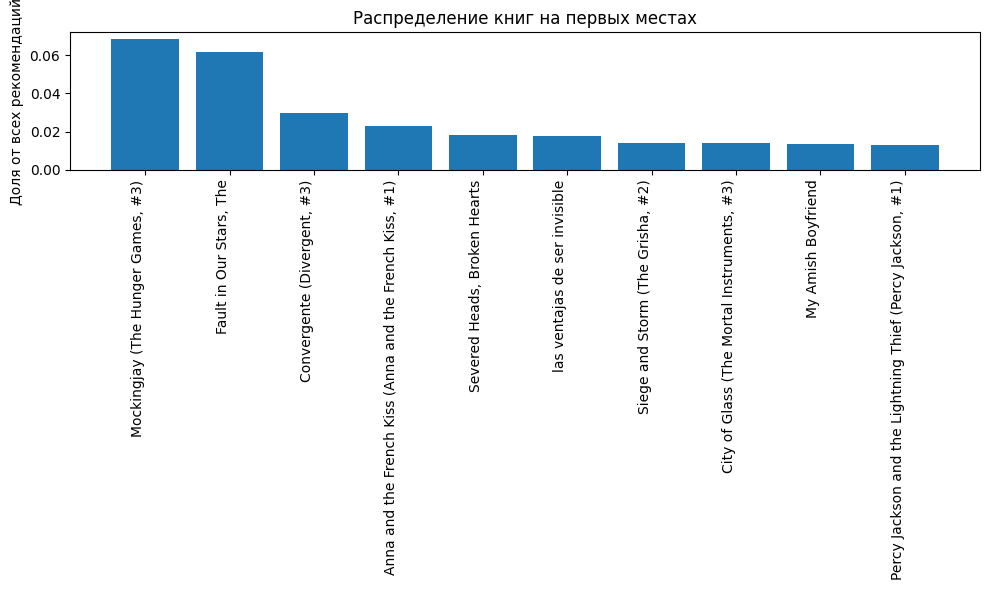

In [24]:
first_items = (
    pl.DataFrame({
        "item_id": test["item_knn_recs"].list.first()
    })
    .join(
        books.select("item_id", "title"),
        on="item_id",
        how="left"
    )
    .group_by("title")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .with_columns(
        (pl.col("count") / pl.col("count").sum()).alias("proportion")
    )
)

top_10 = first_items.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_10["title"].to_list(), top_10["proportion"].to_list())
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение книг на первых местах")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

Кстати, а может ли такой алгоритм порекомендовать "холодные" айтемы?

# **Решение**

## EDA

In [48]:
print(train.shape)
print(test.shape)
print(books.shape)
print(train["user_id"].n_unique())
print(train["item_id"].n_unique())
print(books["item_id"].n_unique())

(11971437, 5)
(185828, 5)
(34322, 9)
349719
31300
34322


In [50]:
import warnings
warnings.filterwarnings("ignore")

mean interactions by user: 34.23
median interactions by user: 10.0
max interactions by user: 7487
mean interactions by book: 382.47
median interactions by book: 33.0
max interactions by book: 91558


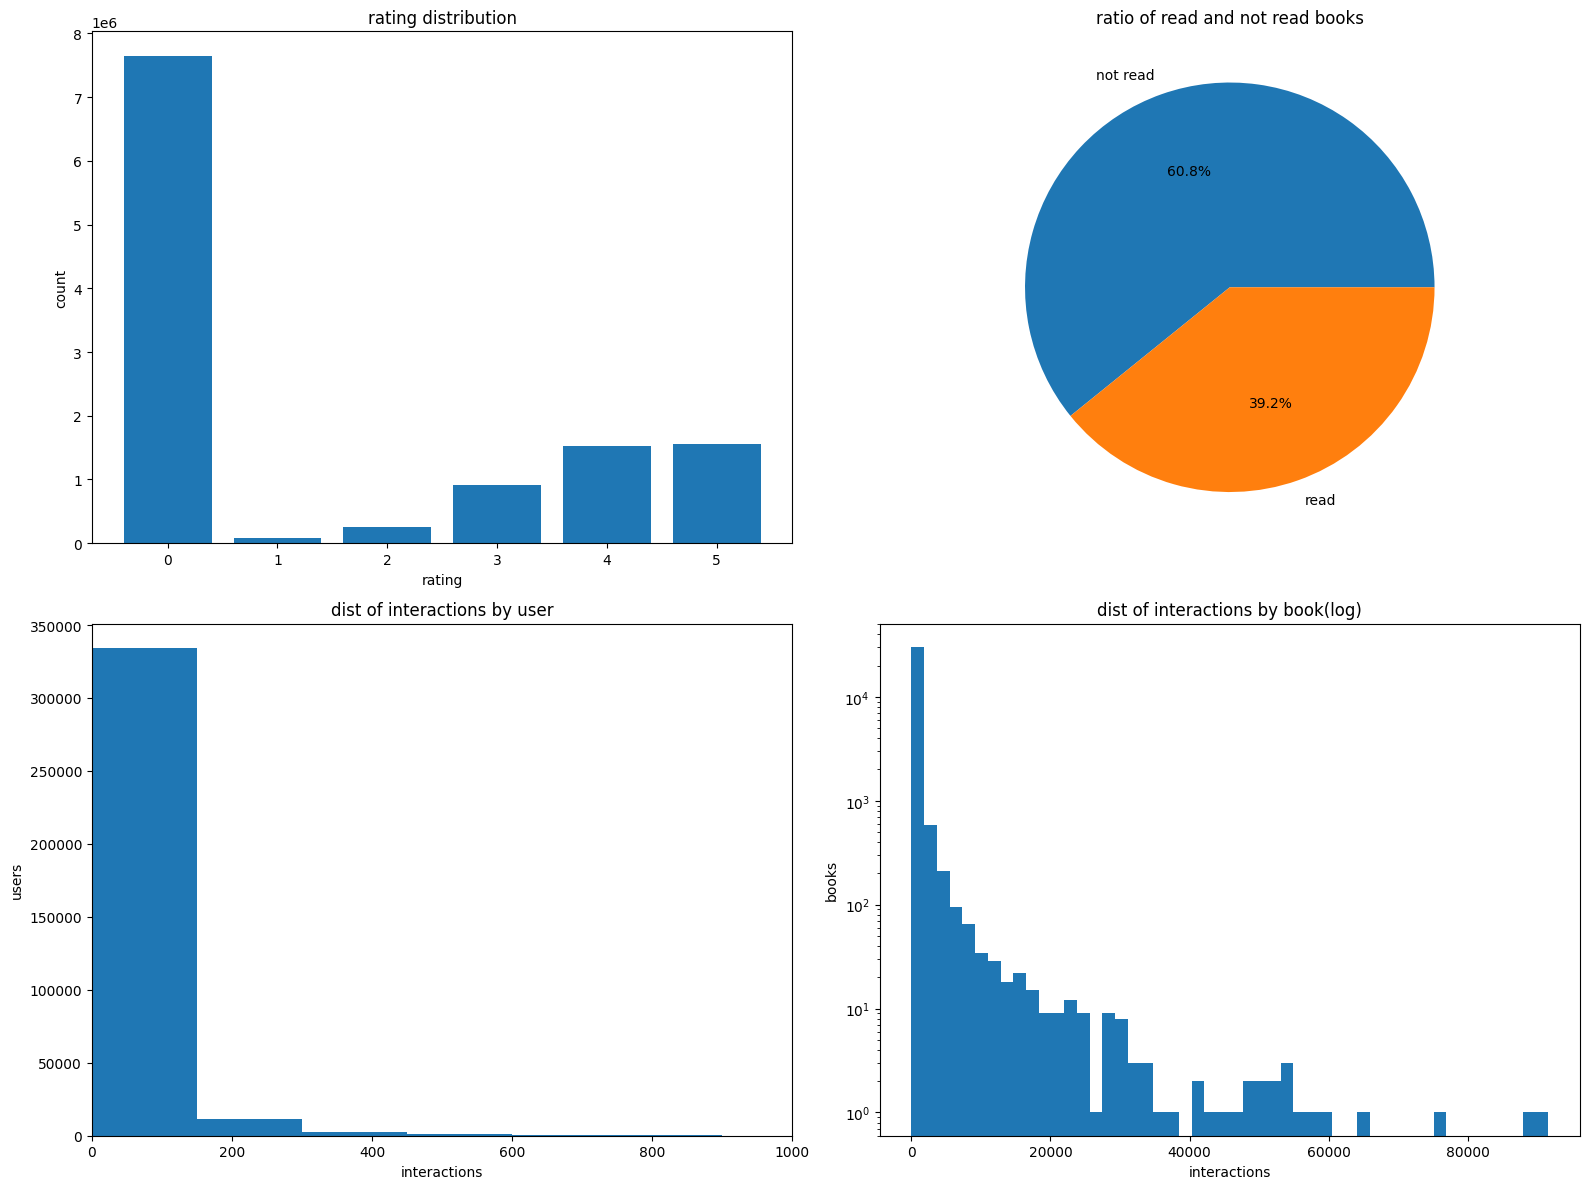

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

rating_counts = train.group_by("rating").agg(pl.count()).sort("rating")
axes[0, 0].bar(rating_counts["rating"].to_list(), rating_counts["count"].to_list())
axes[0, 0].set_title("rating distribution")
axes[0, 0].set_xlabel("rating")
axes[0, 0].set_ylabel("count")

read_counts = train.group_by("is_read").agg(pl.count())
axes[0, 1].pie(
    read_counts["count"].to_list(), 
    labels=["not read", "read"] if read_counts["is_read"][0] == 0 else ["read", "not read"],
    autopct="%1.1f%%"
)
axes[0, 1].set_title("ratio of read and not read books")

user_interactions = train.group_by("user_id").agg(pl.count()).rename({"count": "interactions"})
axes[1, 0].hist(user_interactions["interactions"].to_list(), bins=50)
axes[1, 0].set_title("dist of interactions by user")
axes[1, 0].set_xlabel("interactions")
axes[1, 0].set_ylabel("users")
axes[1, 0].set_xlim(0, 1000)
print(f"mean interactions by user: {user_interactions['interactions'].mean():.2f}")
print(f"median interactions by user: {user_interactions['interactions'].median()}")
print(f"max interactions by user: {user_interactions['interactions'].max()}")

book_interactions = train.group_by("item_id").agg(pl.count()).rename({"count": "interactions"})
axes[1, 1].hist(book_interactions["interactions"].to_list(), bins=50, log=True)
axes[1, 1].set_title("dist of interactions by book(log)")
axes[1, 1].set_xlabel("interactions")
axes[1, 1].set_ylabel("books")
print(f"mean interactions by book: {book_interactions['interactions'].mean():.2f}")
print(f"median interactions by book: {book_interactions['interactions'].median()}")
print(f"max interactions by book: {book_interactions['interactions'].max()}")

plt.tight_layout()

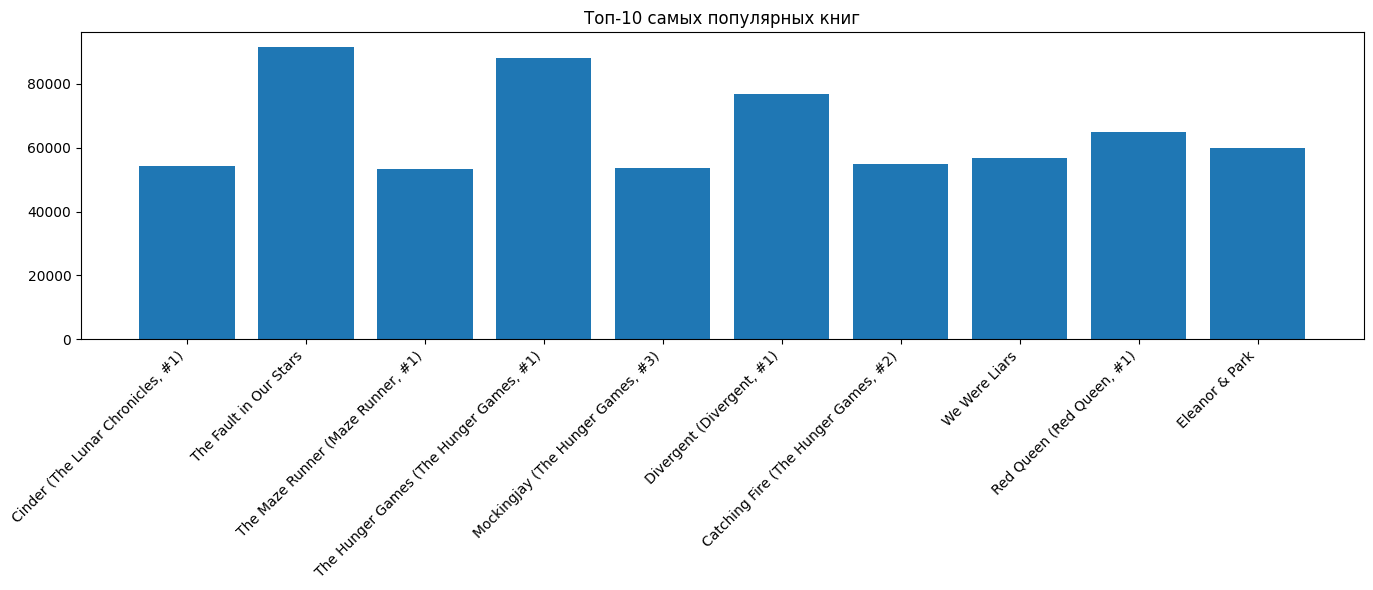

In [ ]:
#хочется вывести еще раз и поближе для сравнения

top_books = book_interactions.sort("interactions", descending=True).head(10)
top_books_with_titles = top_books.join(books.select(["item_id", "title"]), on="item_id")

plt.figure(figsize=(14, 6))
plt.bar(top_books_with_titles["title"].to_list(), top_books_with_titles["interactions"].to_list())
plt.xticks(rotation=45, ha='right')
plt.title("Топ-10 самых популярных книг")
plt.tight_layout()

Text(0, 0.5, 'books')

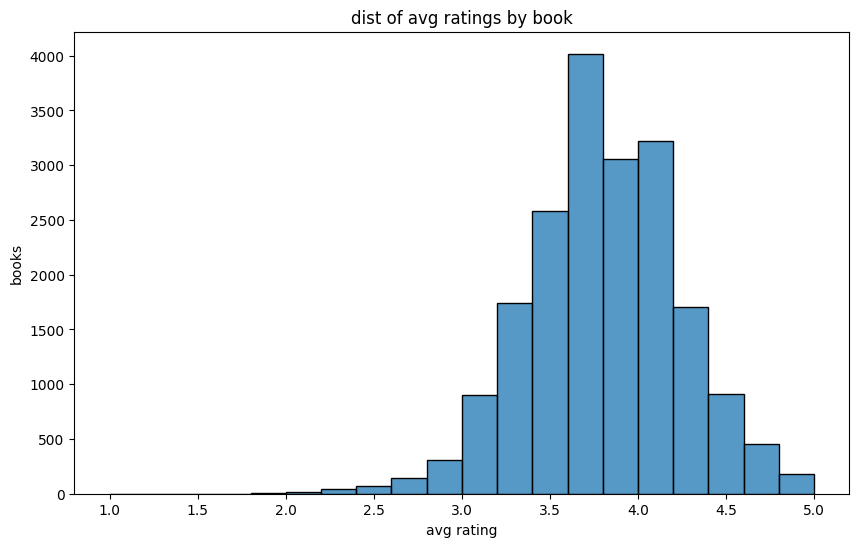

In [69]:
import seaborn as sns

book_avg_ratings = train.filter(pl.col("rating") > 0).group_by("item_id").agg(
    avg_rating=pl.col("rating").mean(),
    count=pl.count()
).filter(pl.col("count") >= 5) #не менее 5 оценок

plt.figure(figsize=(10, 6))
sns.histplot(book_avg_ratings["avg_rating"].to_list(), bins=20)
plt.title("dist of avg ratings by book")
plt.xlabel("avg rating")
plt.ylabel("books")

Возможно, отсюда можно вытащить некоторую информацию о рейтингах, которую потом можно добавить в фичи

Text(0, 0.5, 'interactions')

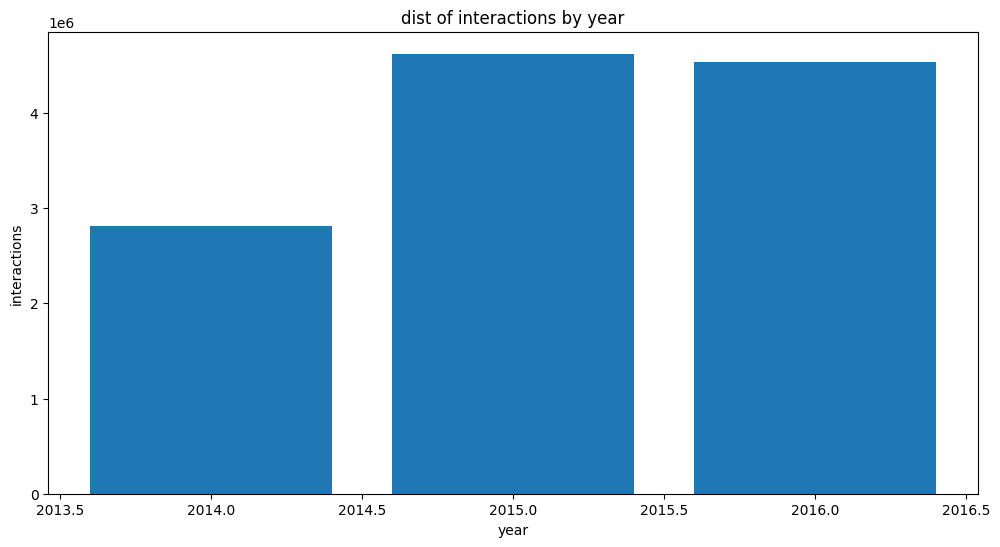

In [54]:
train_with_date = train.clone()

train_with_date = train_with_date.with_columns([
    pl.col("date_added").dt.year().alias("year"),
    pl.col("date_added").dt.month().alias("month"),
    pl.col("date_added").dt.weekday().alias("weekday")
])

year_counts = train_with_date.group_by("year").agg(pl.count())
plt.figure(figsize=(12, 6))
plt.bar(year_counts["year"].to_list(), year_counts["count"].to_list())
plt.title("dist of interactions by year")
plt.xlabel("year")
plt.ylabel("interactions")

([<matplotlib.axis.XTick at 0x311e02c10>,
 [Text(0, 0, 'Пн'),
  Text(1, 0, 'Вт'),
  Text(2, 0, 'Ср'),
  Text(3, 0, 'Чт'),
  Text(4, 0, 'Пт'),
  Text(5, 0, 'Сб'),
  Text(6, 0, 'Вс')])

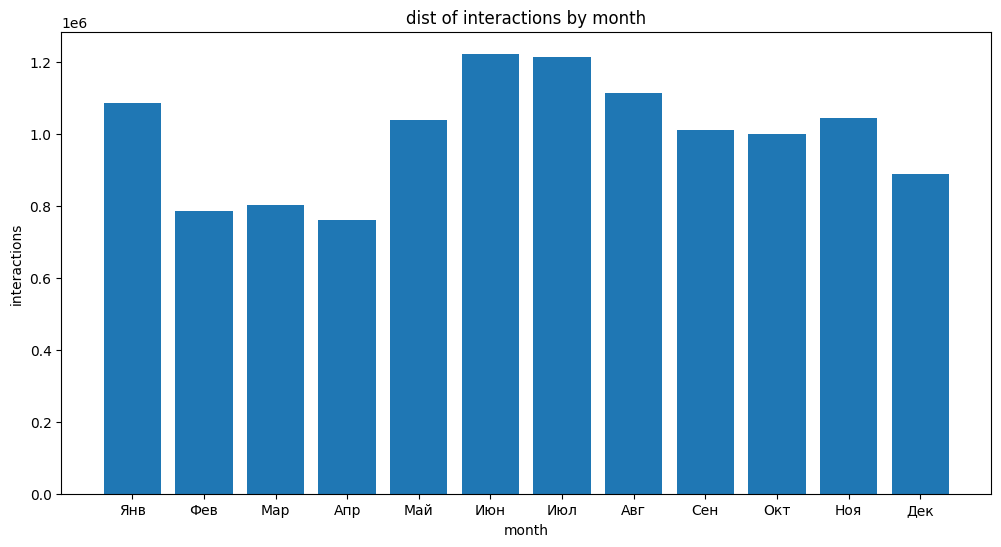

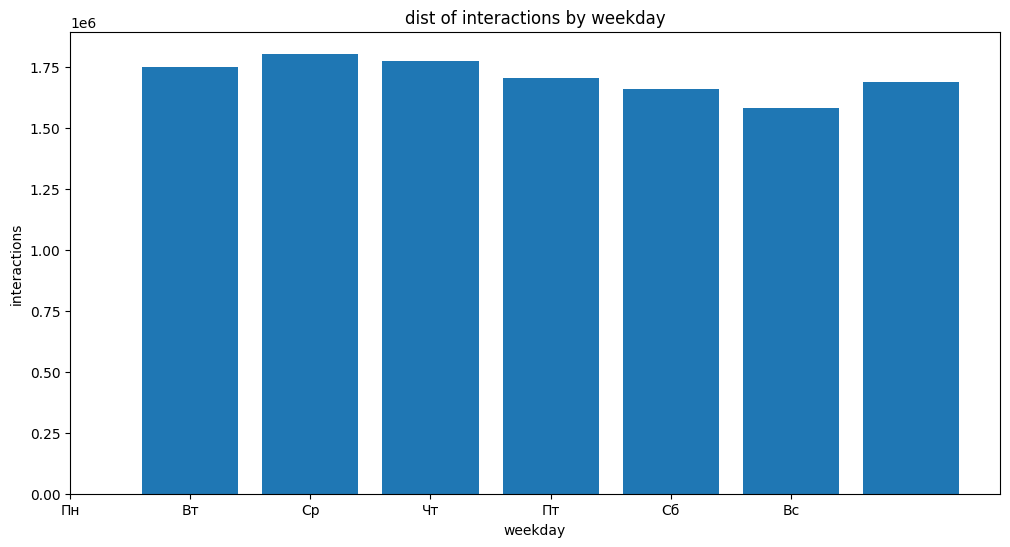

In [55]:
month_counts = train_with_date.group_by("month").agg(pl.count())
plt.figure(figsize=(12, 6))
plt.bar(month_counts["month"].to_list(), month_counts["count"].to_list())
plt.title("dist of interactions by month")
plt.xlabel("month")
plt.ylabel("interactions")
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])

weekday_counts = train_with_date.group_by("weekday").agg(pl.count())
plt.figure(figsize=(12, 6))
plt.bar(weekday_counts["weekday"].to_list(), weekday_counts["count"].to_list())
plt.title("dist of interactions by weekday")
plt.xlabel("weekday")
plt.ylabel("interactions")
plt.xticks(range(0, 7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

Как-то пока не очень информативно, кроме того факта, что рейтинги ставят (и вероятно читают) меньше с февраля по апрель

Попробуем проанализировать теги

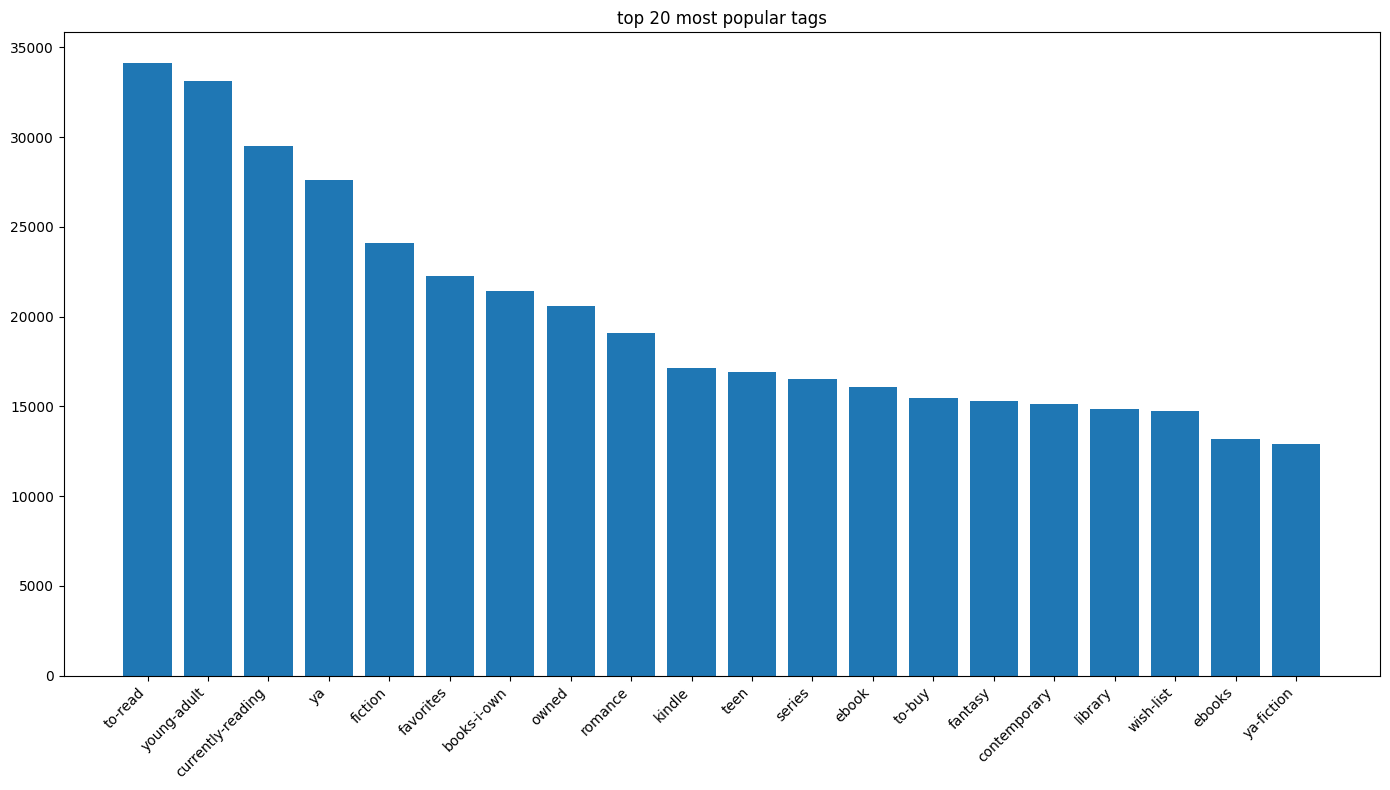

In [56]:
from collections import Counter

all_tags = []
for tags_list in books["tags"]:
    all_tags.extend(tags_list)

tag_counts = Counter(all_tags)
top_20_tags = dict(tag_counts.most_common(20))

plt.figure(figsize=(14, 8))
plt.bar(top_20_tags.keys(), top_20_tags.values())
plt.xticks(rotation=45, ha='right')
plt.title("top 20 most popular tags")
plt.tight_layout()

tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

In [ ]:
all_tags = []
for tags_list in books["tags"]:
    all_tags.extend(tags_list)

tag_counts = Counter(all_tags)
print(f"unique tags: {len(tag_counts)}")

thresholds = [1, 5, 10, 50]
for threshold in thresholds:
    frequent_tags = {tag: count for tag, count in tag_counts.items() if count >= threshold}
    print(f"tags with frequency >= {threshold}: {len(frequent_tags)}")

unique tags: 189739
tags with frequency >= 1: 189739
tags with frequency >= 5: 40822
tags with frequency >= 10: 20760
tags with frequency >= 50: 4553


In [72]:
books_enriched.write_parquet(data_folder + "books_enriched.pq")

print(f"{train.shape[0]} взаимодействий, {train['user_id'].n_unique()} пользователей и {books.shape[0]} книг")
print(f"Прочитано книг {train.filter(pl.col('is_read') == 1).shape[0] / train.shape[0]:.2%}")
print(f"Оцененных книг {train.filter(pl.col('rating') > 0).shape[0] / train.shape[0]:.2%}")
print(f"Max число взаимодействий {book_interactions['interactions'].max()}")
print(f"Mean число взаимодействий {book_interactions['interactions'].mean():.2f}")
print(f"Входят в серии {books.filter((pl.col('series').list.len() > 0) & ~pl.col('series').list.contains(None)).shape[0] / books.shape[0]:.2%} книг")

11971437 взаимодействий, 349719 пользователей и 34322 книг
Прочитано книг 39.19%
Оцененных книг 36.10%
Max число взаимодействий 91558
Mean число взаимодействий 382.47
Входят в серии 56.14% книг


## Набор валидационных метрик и обоснование их выбора

In [73]:
cold_items = set(test_exploded["item_id"].to_list()) - set(train["item_id"].to_list())
warm_items = set(test_exploded["item_id"].to_list()) - cold_items

print(f"Количество холодных айтемов: {len(cold_items)}")
print(f"Количество теплых айтемов: {len(warm_items)}")

Количество холодных айтемов: 1775
Количество теплых айтемов: 25592


- Можно добавить MAP@k (mean average precision), который сильнее штрафует за неправильное ранжирование, чем NDCG@k, а также добавляет к имеющимся метрикам информацию о доле релевантных среди k рекомендованных, с учетом их позиции в ранжировании. С учетом фокуса на холодных айтемах, эта метрика позволяет оценить способность модели точно выявлять релевантные холодные айтемы и ставить их на верх списка рекомендаций. В отличие от Recall@k, который учитывает только наличие релевантного айтема в списке, и NDCG@k, который использует логарифмическое убывание значимости позиции, MAP@k более строго штрафует за низкое расположение релевантных айтемов. Плюс он нормализуется относительно идеального ранжирования для каждого юзера, что добавляет устойчивости к различному числу релевантных айтемов для разных юзеров. Формулка: 

$$Precision@k = \dfrac{1}{k} \displaystyle{\sum_{i = 0}^{k} \left[y_i = 1\right]}$$
где $y_i$ - релевантность айтема, который поставлен моделью на позицию i
$$AP@k = \dfrac{1}{\displaystyle{\sum_{i = 0}^{k} y_i}} \displaystyle{\sum_{i = 0}^{k} y_i precision@i}$$
Тогда определим MAP@k для набора запросов Q:

$$MAP@k(Q) = \dfrac{1}{|Q|} \displaystyle{\sum_{q \in Q} AP@k(q)}$$

- Можно добавить Serendipity@k - оцениваем способность модели предлагать неожиданные, но релевантные рекомендации. С учетом холодных айтемов - оценивает, насколько модель способна выходить за рамки очевидных предпочтений пользователя и предлагать новые айтемы(отличающиеся от, например, TopPopular). Про это прочитала в цикле по ссылке и нашла статью "Beyond accuracy: evaluating recommender systems by coverage and serendipity" (Mouzhi Ge, Carla Delgado-Battenfeld, and Dietmar Jannach. 2010)

**Реализация метрик и моделей в файле models_pipelines.ipynb**